In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# Imports


In [2]:
# Ignore Warnings
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm

from xgboost import XGBClassifier

# Suppress scientific notation in pandas
pd.options.display.float_format = "{:.2f}".format
# Show sklearn pipeline diagram
from sklearn import set_config
set_config(display='diagram')
# Suppress scientific notation in numpy
np.set_printoptions(suppress=True)

# Load Dataset


In [3]:
trainCSV = pd.read_csv(r"/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
testCSV = pd.read_csv(r"/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

# Exploratory Data Analysis


## Snippet of Datasets


In [4]:
trainCSV.head(5)

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [5]:
testCSV.head(5)

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,86,45,41384,Black Bean ‘n’ Pumpkin Chili,sp_aUSaElGf_41384_c_341929,u_1oKc4U6bh65cEli8Z8eTIf98Vpr,kalloween,1,1622718043,0,0,0,100,This was so good!! The pumpkin was perfect as...
1,102,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_274545,u_1oKW5seFLQMSwAeOfBVmwJizy5D,chocolate desert,1,1622717685,0,0,1,100,"So good! Could not stop eating them, so bad...."
2,156,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_398512,u_1oKZ6GUIAIol8xe6oEI7t1Mpxdz,Vantreesta,1,1622718307,0,0,0,100,I use a small ladle to fill muffin cups.
3,18,89,1324,Porcupine Meatballs,sp_aUSaElGf_1324_c_431662,u_1oKWCP33NVk4Osfpu4VJuIckEF0,Roberta L.Beauchamp,1,1622648872,0,4,3,212,I made this and followed the instructions as d...
4,27,70,32264,Easy Chicken Enchiladas,sp_aUSaElGf_32264_c_423935,u_1oKVhIJMuUlrSCVkbO1jheVTol8,fhquilting,1,1622718460,0,0,1,100,Very Good! I used corn tortillas. Used fresh...


## Shapes of Datasets


In [6]:
print("Shape of training dataset:",trainCSV.shape)
print("Shape of test dataset:",testCSV.shape)

Shape of training dataset: (13636, 15)
Shape of test dataset: (4546, 14)


## Columns in Datasets


In [7]:
print("Columns in training dataset:\n",list(trainCSV.columns),'\n')
print("Columns in testing dataset:\n",list(testCSV.columns))

Columns in training dataset:
 ['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID', 'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore', 'Recipe_Review'] 

Columns in testing dataset:
 ['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID', 'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Recipe_Review']


## Datatypes of Colums and Missing Values


In [8]:
trainCSV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [9]:
testCSV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 4546 non-null   int64 
 1   RecipeNumber       4546 non-null   int64 
 2   RecipeCode         4546 non-null   int64 
 3   RecipeName         4546 non-null   object
 4   CommentID          4546 non-null   object
 5   UserID             4546 non-null   object
 6   UserName           4546 non-null   object
 7   UserReputation     4546 non-null   int64 
 8   CreationTimestamp  4546 non-null   int64 
 9   ReplyCount         4546 non-null   int64 
 10  ThumbsUpCount      4546 non-null   int64 
 11  ThumbsDownCount    4546 non-null   int64 
 12  BestScore          4546 non-null   int64 
 13  Recipe_Review      4546 non-null   object
dtypes: int64(9), object(5)
memory usage: 497.3+ KB


### Replacing Missing Values in TrainCSV


There are 2 missing values in the "Recipe_Review" column in trainCSV dataset. These missing "Recipe_Reviews" have been imputed with the string "None".


In [10]:
trainCSV['Recipe_Review'].isna().sum()

2

In [11]:
trainCSV['Recipe_Review'] = trainCSV['Recipe_Review'].fillna('None')

## Descriptive Statistics of Numerical Columns


The following columns have been dropped as their descriptive statistics have no logical use.

```
['ID','RecipeCode','CreationTimestamp']
```


In [12]:
trainCSV.drop(columns=['ID','RecipeCode','CreationTimestamp']).describe().T

,count,mean,std,min,25%,50%,75%,max
RecipeNumber,13636.00,38.62,29.67,1.00,12.00,33.00,63.00,100.00
UserReputation,13636.00,2.16,10.09,0.00,1.00,1.00,1.00,510.00
ReplyCount,13636.00,0.01,0.14,0.00,0.00,0.00,0.00,3.00
ThumbsUpCount,13636.00,1.10,4.17,0.00,0.00,0.00,0.00,80.00
ThumbsDownCount,13636.00,0.54,3.27,0.00,0.00,0.00,0.00,126.00
Rating,13636.00,4.29,1.54,0.00,5.00,5.00,5.00,5.00
BestScore,13636.00,153.13,140.99,0.00,100.00,100.00,100.00,946.00


In [13]:
testCSV.drop(columns=['ID','RecipeCode','CreationTimestamp']).describe().T

,count,mean,std,min,25%,50%,75%,max
RecipeNumber,4546.00,38.88,30.13,1.00,11.00,32.00,64.00,100.00
UserReputation,4546.00,2.16,9.80,0.00,1.00,1.00,1.00,520.00
ReplyCount,4546.00,0.01,0.14,0.00,0.00,0.00,0.00,3.00
ThumbsUpCount,4546.00,1.06,4.30,0.00,0.00,0.00,0.00,106.00
ThumbsDownCount,4546.00,0.57,4.02,0.00,0.00,0.00,0.00,122.00
BestScore,4546.00,153.26,141.36,12.00,100.00,100.00,100.00,931.00


## Check if Dataset is Balanced or Not


### Balance in Target Variable

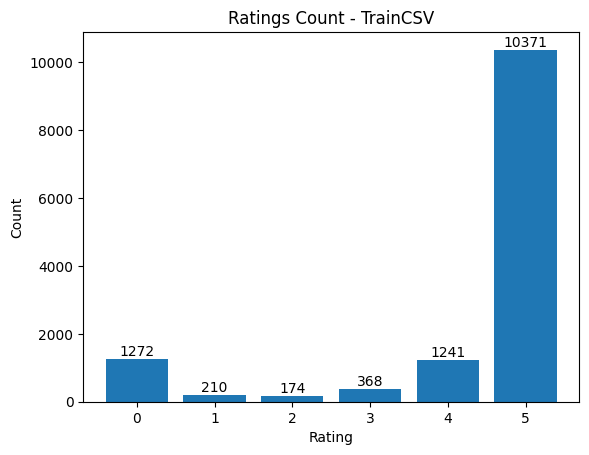

In [14]:
trainCSVLabelCounts = trainCSV.Rating.value_counts()

fig,ax = plt.subplots()
ax.bar(
    list(trainCSV.Rating.unique()), # x-axis -> unique ratings
    [trainCSVLabelCounts.loc[i] for i in list(trainCSV.Rating.unique())] # y-axis -> count of corresponding unique rating 
)

# Show value labels
ax.bar_label(ax.containers[0], label_type='edge')

ax.set_title("Ratings Count - TrainCSV")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")

plt.show()

- The dataset is highly imbalanced: among the 6 classes, the majority of the samples belong to the class 5 i.e. rating is 5. 

- Out of 13,636 samples in the training dataset, 10,371 i.e. almost 76% of the samples belong to the class 5. 

- The number of samples in the class 5 surpasses the number of samples in all the other classes combined, making the dataset extremely imbalanced.

- Moreover, if we ignore the class 5 for a moment and consider only the other classes, we can observe that within those classes/ratings (0,1,2,3,4) also, the dataset is imbalanced.

- There number of samples for ratings 0 and 4 are more or less in the same range, but the number of samples in classes 1,2, and 3 are very less as compared to classes 0 and 4.

### Balance in Numerical Features

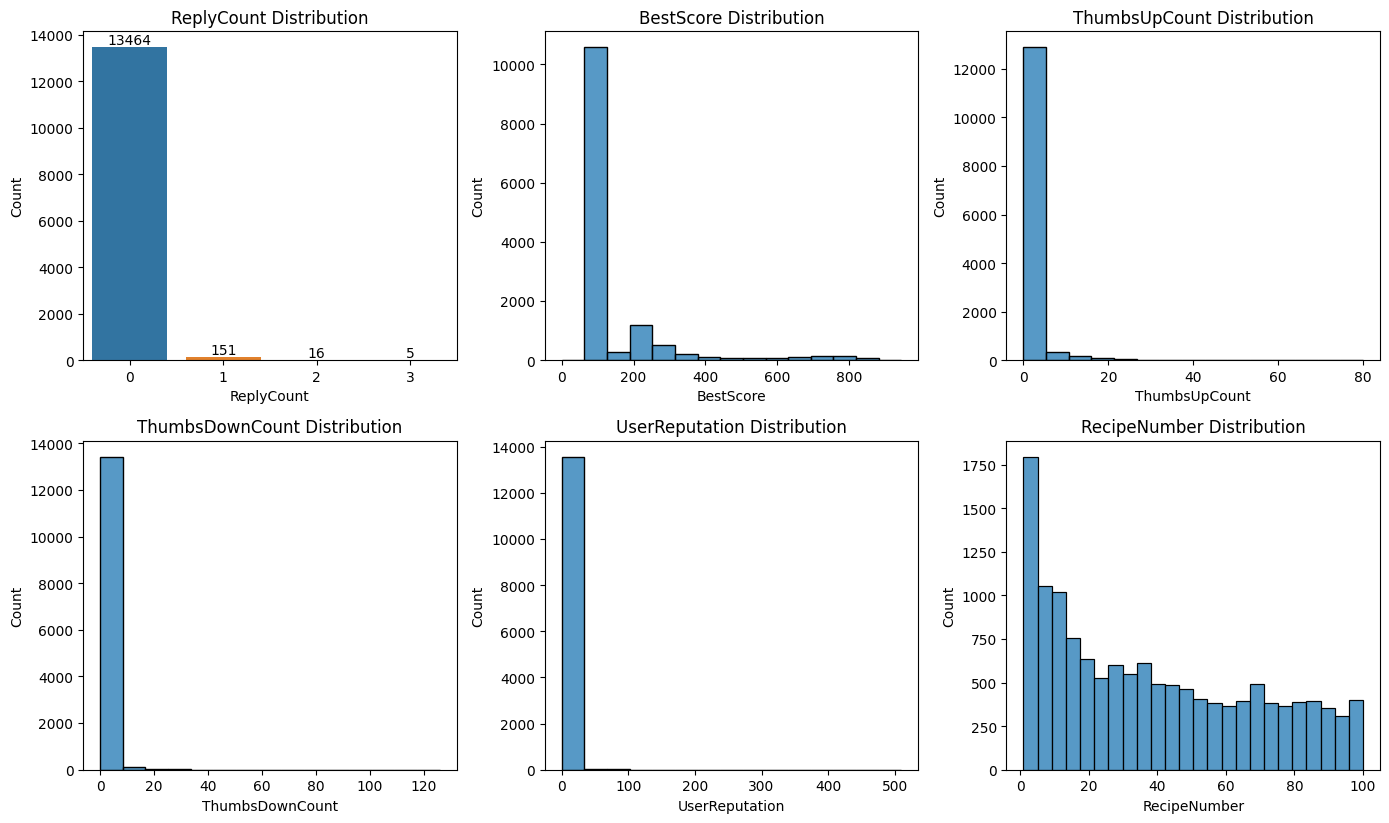

In [15]:
# Function to create histograms
def create_hist(data: pd.Series, title=None):
  # Create a histplot with custom bin values
  ax = sns.histplot(x=data)

  # ax.bar_label(ax.containers[0])  # Shows y values above each bar of histplot
  if title!=None: ax.set_title(title)
  return ax

# Plot of Distributions
plt.figure(figsize=(14, 12))

# Distirbution of column ReplyCount shown using bar chart not histogram because this column has very few unique values which are discrete too 
replyCountDF = pd.DataFrame(trainCSV['ReplyCount'].value_counts()) # Find ReplyCount's value counts and convert to dataframe
replyCountDF.reset_index(inplace=True, drop=False) # reset index
replyCountDF.rename(columns={'index':'ReplyCount'})
plt.subplot(3,3,1)
rcBar = sns.barplot(replyCountDF, x='ReplyCount', y='count') #trainCSV.ReplyCount.value_counts()
rcBar.bar_label(rcBar.containers[0])  # Shows y values above each bar of histplot
rcBar.set_title("ReplyCount Distribution")
rcBar.set_xlabel("ReplyCount")
rcBar.set_ylabel("Count")

# List of columns of which histogram is to be made along with their position on the plot
histCols = [(2,"BestScore"), (3,"ThumbsUpCount"), (4,"ThumbsDownCount"), (5,"UserReputation"), (6,"RecipeNumber")]

# Loop to create histograms
for tup in histCols:
    plt.subplot(3, 3, tup[0])
    title = str(tup[1]) + " Distribution"
    create_hist(trainCSV[tup[1]], title)#, str(trainCSV[tup[1]]+" Distribution"))
    # sns.histplot(trainCSV[tup[1]])
    # plt.title(tup[1])

plt.tight_layout()  # Adjust spacing to prevent overlapping
plt.show()

- None of the numerical features is adequately balanced. 

- All these features have very high imbalance, some haveing higher imbalance than even the target variable.

- `RecipeNumber` is the most balanced out of all the numerical features but this too is quite imbalanced.

### Three-fold Imbalance in the Dataset

- Thus, there is three-fold imbalance in the dataset:

    1. the samples in class 5 outnumber all the other classes combined by a huge margin,
    
    2. there is imbalance even in the remaining classes, with the samples of classes 0 and 4 outnumbering those of classes 1,2, and 3,
    
    3. the numerical features are highly imbalanced as well.

## Correlation Among Features


Text(0.5, 1.0, 'Correlation Matrix')

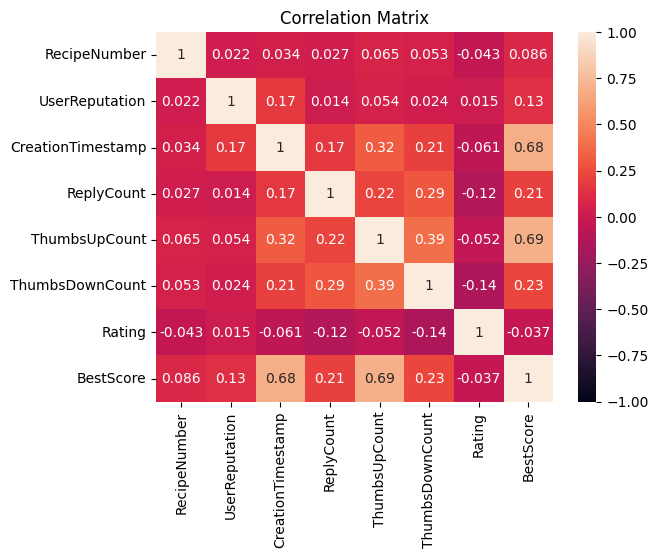

In [16]:
# List of non-numeric columns
drop_cols = ["ID","RecipeCode","RecipeName","CommentID","UserID","UserName","Recipe_Review"]
# Drop non-numeric columns before creating correlation heatmap
corrDF = trainCSV.drop(columns=drop_cols)
# Create correlation heatmap
corrMatrix = sns.heatmap(corrDF.corr(), vmin=-1, vmax=1, annot=True)
corrMatrix.set_title("Correlation Matrix")

- `BestScore` is positively correlated with `CreationTimestamp` (0.68) and `ThumbsUpCount` (0.69). Thus using `BestScore` with any of these 2 features might reduce the accuracy.

- In general, numeric features have negligible correlation with the label column `Rating`, as is evident in the below heatmap.


Text(0.5, 1.0, 'Correlation with Rating')

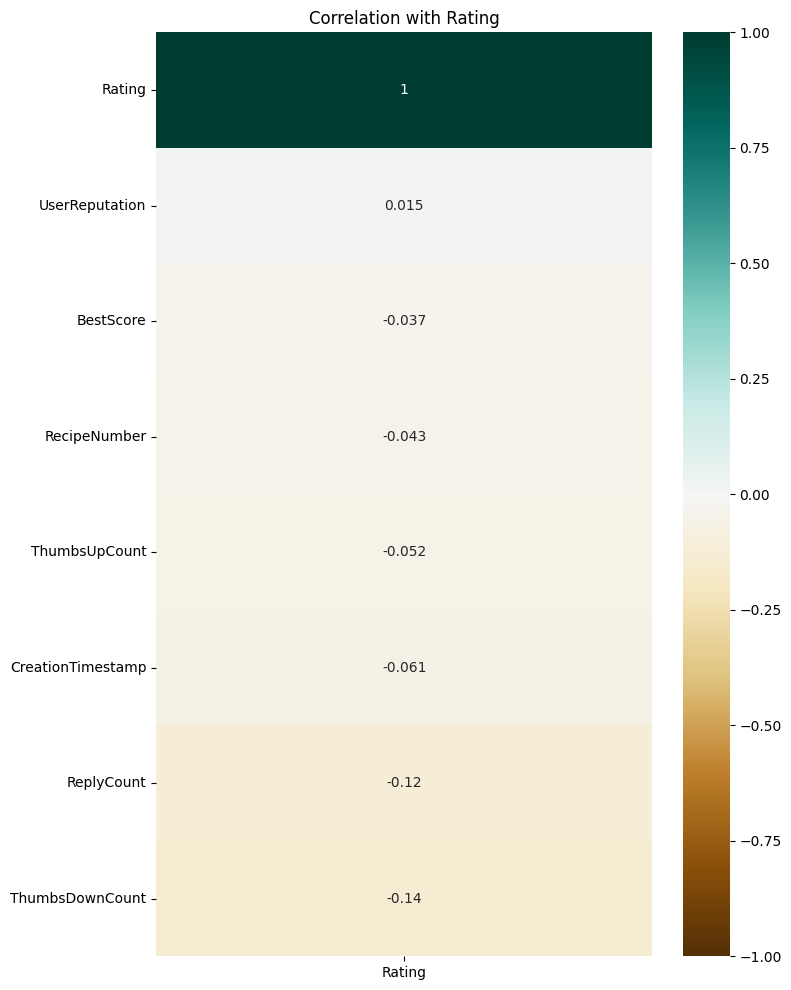

In [17]:
plt.figure(figsize=(8, 12))
corrWithRating = sns.heatmap(corrDF.corr()[['Rating']].sort_values(by='Rating', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
corrWithRating.set_title('Correlation with Rating')

# Feature Engineering

In [18]:
from copy import deepcopy
# Copy of trainCSV on which feature engineering is demonstrated
featuresDF = deepcopy(trainCSV)

### Encoding `RecipeName` Using `OneHotEncoder`

In [19]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)    # by default returns sparse matrix, set that to false to convert to dataframe
# Encode recipe names
ohe_ = ohe.fit_transform(featuresDF[['RecipeName']])  
# Create a dataframe of new encoded features
ohe_features = pd.DataFrame(ohe_, columns=ohe.get_feature_names_out())
ohe_features.rename(columns=lambda x: x[11:],inplace=True)  # Rename columns. Remove the "RecipeName_" string added in the beginnning of each column by OneHotEncoder
ohe_features

,Amish Breakfast Casserole,Apple Pie,Asian Chicken Thighs,Bacon Macaroni Salad,Baked Mushroom Chicken,Baked Spaghetti,Baked Tilapia,Banana Bars with Cream Cheese Frosting,Basic Banana Muffins,Basic Homemade Bread,...,Taco Lasagna,Tennessee Peach Pudding,Teriyaki Chicken Thighs,Traditional Lasagna,Twice-Baked Potato Casserole,Vegetarian Linguine,White Bean Chicken Chili,Winning Apple Crisp,Zucchini Cupcake,Zucchini Pizza Casserole
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13631,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13632,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13633,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13634,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### New Features From Column `CreationTimestamp`

- Here, the`CreationTimestamp` column was used to extract the day of the week and the hour of the day. 

- The day of the week became a feature in itself named `DayOfWeek`.

- The hour of the day was used to create another feature called `DayOrNight`.

- If the hour was between 7 and 19 (19 excluded) then `DayOrNight`=1 representing day-time, else `DayOrNight`=0 representing night-time.

In [20]:
import datetime as dt
d = featuresDF["CreationTimestamp"]
dft = pd.DataFrame(d)

# Function to extract dayOrNight and dayOfWeek from timestamp
def processTimestamp(timestamp):
    dt_object = dt.datetime.fromtimestamp(timestamp)
    hrOfDay = dt_object.hour
    dayOrNight = ''   # 1 represents Day, 0 represents Night
    if 7<=hrOfDay<19:
        dayOrNight = 1   # 1 for day
    else: dayOrNight = 0  # 0 for night
    dayOfWeek = dt_object.weekday()
    return dayOrNight, dayOfWeek    

featuresDF[['DayOrNight', 'DayOfWeek']] = featuresDF['CreationTimestamp'].apply(lambda row: pd.Series(processTimestamp(row)))
featuresDF[['DayOrNight','DayOfWeek']]  # Display the 2 new columns

,DayOrNight,DayOfWeek
0,1,3
1,1,3
2,1,3
3,1,2
4,1,3
...,...,...
13631,1,3
13632,1,3
13633,1,3
13634,1,3


### New Features From Column `RecipeName`

- Using `RecipeName` a new feature was created called `RecipeNameRating`.

- The values in this feature are the weighted mean rating for that recipe.

- Weighted mean rating, or 'wMeanRating' is a score created to find the weighted average rating that a given recipe has got.

- The logic behind creating this feature was to tackle the imbalance in the ratings in the training data.

- To calculate the wMearRating, the number of 0 ratings, 1 ratings, and so forth, are calculated for a particular recipe. Then, each ratings' count is assigned a weight (which in this case is a logarithm of the count of another specified rating) in an attempt to balance the ratings.

- The wMeanRating is calculated for each recipe and in the training data, a column is created where this score is mentioned for that record's recipe.

- `RecipeName` was used as the base for this exercise because intuitively, there are always some recipes which are more preferred by people thatn others. There is a natural relation between a recipe and its rating. This feature attempted to capture that relation using the given training dataset.

In [21]:
# Pivot table showing, for each recipe, the counts of each rating it has received
recipeRating = pd.pivot_table(featuresDF, values='ID', index=['RecipeName'],
                       columns=['Rating'], aggfunc="count")
recipeRating.reset_index(inplace=True)  # Convert the index, which represents the names of the recipes, into a column of the table
recipeRating.rename(columns={'index':'RecipeName'}) # Rename the above converted column
recipeRating.fillna(0,inplace=True) # Replace np.nan values with 0
recipeRating

Rating,RecipeName,0,1,2,3,4,5
0,Amish Breakfast Casserole,12.00,4.00,2.00,9.00,27.00,195.00
1,Apple Pie,16.00,8.00,8.00,5.00,12.00,116.00
2,Asian Chicken Thighs,5.00,2.00,0.00,2.00,10.00,94.00
3,Bacon Macaroni Salad,2.00,1.00,1.00,5.00,10.00,53.00
4,Baked Mushroom Chicken,11.00,0.00,1.00,1.00,5.00,101.00
...,...,...,...,...,...,...,...
95,Vegetarian Linguine,1.00,0.00,0.00,1.00,0.00,17.00
96,White Bean Chicken Chili,12.00,0.00,0.00,6.00,19.00,61.00
97,Winning Apple Crisp,16.00,4.00,3.00,11.00,13.00,94.00
98,Zucchini Cupcake,19.00,0.00,2.00,3.00,25.00,155.00


In [22]:
# Function to give a weighted mean rating score to each recipe
# Here the input df is the pivot table recipRating created in the previous cell
def wMeanRating(df:pd.DataFrame) -> dict:    
    npDF = df.to_numpy()    # Convert input dataframe to numpy array 
    d = {}  # Output dictionary in which recipe names will be keys and weighted mean rating will be the value

    for row in npDF:
        d[row[0]] = np.average(
            # List of ratings
            [0,1,2,3,4,5],
            # List of weights
            weights = [
                np.log(row[4]+1),   # Weight for rating 0 based on log(count(rating=3))
                np.log(row[5]+1),   # Weight for rating 1 based on log(count(rating=4))
                np.log(row[5]+1),   # Weight for rating 2 based on log(count(rating=4))
                np.log(row[4]+1),   # Weight for rating 3 based on log(count(rating=3))
                np.log(row[5]+1),   # Weight for rating 4 based on log(count(rating=4))
                np.log(row[6]+1)   # Weight for rating 5 based on log(count(rating=5))
            ]   # Add 1 inside log() to avoid nan in the final output as log(0) might create an issue
            )  
    return d

# Function which matches a given recipe with its corresponding wMeanRating score
def matchRating(d:dict, row):
    try:
        return d[row]
    except KeyError:
        return 0

# Dictionary of recipes with their wMeanRating score
wmrDict = wMeanRating(recipeRating)
# print(wmrDict)

featuresDF['RecipeNameRating'] = featuresDF['RecipeName'].apply(
    lambda row: matchRating(wmrDict,row)
)
featuresDF[['RecipeNameRating']]

,RecipeNameRating
0,3.72
1,2.99
2,2.81
3,3.04
4,2.89
...,...
13631,2.93
13632,2.92
13633,2.99
13634,2.82


# Choice of Features

- Since the numeric features have negligible correlation with the label vector, the text column `Recipe_Reviews` has been used to train the models.

- Moreover, while building baseline models, these numeric features were used in various combinations to train various models but no combination of the numeric features gave the daequate accuracy.

- Intuitively, it might seem that most of the columns in the datset should be related to `Rating` to some or the other degree. 

- For instance, logically, the `RecipeName` column should be related to `Rating` as certain recipes might in general attract a particular range of rating. For example, if "chocolate cake" were a recipe, there might be many people who like it and hence this recipe may in general get a high rating (say 4 or 5). Alternatively, in real life there are recipes attracting lower ratings.

- However, such intuitive logic did not result in the required accuracy while training the models. Columns like `RecipeName`, `UserName`, `BestScore`, etc. actually did not affect the accuracy. On using these columns, the accuracy obtained on the test data was a only little over 76% and did not touch 77%. 

- This might be attributed to the extreme imbalance in the dataset. Had there been more samples for other ratings and thus the data more balanced, columns other than `Recipe_Reviews` might have played a more important role.

- Even the new features engineered from the existing features were unable to achieve the required accueracy.

- On the other hand, the text column `Recipe_Reviews` alone gave the required minimum accuracy when transformed with `TFIDFVectorizer`.

- Even when numeric columns were used along with `Recipe_Reviews`, the models often overfitted during training and did not reach the minimum required accuracy of 77% during testing. Those columns were only reducing the overall accuracy of the model and hence were dropped.


# KNN (K-Nearest Neighbors)


In [23]:
xtrainKnn, xtestKnn, ytrainKnn, ytestKnn = train_test_split(trainCSV['Recipe_Review'], trainCSV['Rating'], test_size=0.2, stratify=trainCSV['Rating'], random_state=3)
xtrainKnn.shape, xtestKnn.shape, ytrainKnn.shape, ytestKnn.shape

((10908,), (2728,), (10908,), (2728,))

### Tuning KNN


In [24]:
# knnPipe = Pipeline([
#     ('tiff',TfidfVectorizer()),
#     ('knn',KNeighborsClassifier())
# ])

# parameters = {
#     "tiff__ngram_range":[(1,2),(1,3)],
#     "tiff__max_df":[0.2,0.5],
#     "tiff__min_df":[1],
#     "tiff__sublinear_tf":[True,False],
#     "tiff__norm":["l1","l2"],
#     "knn__n_neighbors":[15,55,75]
# }

# knn = GridSearchCV(
#     estimator = knnPipe,
#     param_grid = parameters,
#     cv=4,
#     scoring = "accuracy",
#     n_jobs = -1
# )

# knn.fit(xtrainKnn, ytrainKnn)

# knn.best_params_
"""
{'knn__n_neighbors': 15,
 'tiff__max_df': 0.2,
 'tiff__min_df': 1,
 'tiff__ngram_range': (1, 2),
 'tiff__norm': 'l2',
 'tiff__sublinear_tf': True}
"""

"\n{'knn__n_neighbors': 15,\n 'tiff__max_df': 0.2,\n 'tiff__min_df': 1,\n 'tiff__ngram_range': (1, 2),\n 'tiff__norm': 'l2',\n 'tiff__sublinear_tf': True}\n"

### Training KNN


In [25]:
knn = Pipeline([
    ('tiff',TfidfVectorizer(ngram_range=(1,2), max_df=0.2, min_df=1, sublinear_tf=True)),
    ('knn',KNeighborsClassifier(n_neighbors=15))
])

In [26]:
knn.fit(trainCSV["Recipe_Review"], trainCSV["Rating"])    # Gives test accuracy of 0.76264

Pipeline(steps=[('tiff',
                 TfidfVectorizer(max_df=0.2, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('knn', KNeighborsClassifier(n_neighbors=15))])

In [27]:
knn.score(xtestKnn, ytestKnn)

0.7716275659824047

In [28]:
# Prediction on TestCSV
knn_out_pred = knn.predict(testCSV["Recipe_Review"])

# Logistic Regression (Best Performing Model)


In [29]:
xtrainLog, xtestLog, ytrainLog, ytestLog = train_test_split(trainCSV['Recipe_Review'], trainCSV['Rating'], test_size=0.2, stratify=trainCSV['Rating'], random_state=24)
xtrainLog.shape, xtestLog.shape, ytrainLog.shape, ytestLog.shape

((10908,), (2728,), (10908,), (2728,))

### Tuning Logistic Regression


In [30]:
# logPipe = Pipeline([
#     ('tiff',TfidfVectorizer(min_df=1, norm=None)),
#     ('log',LogisticRegression(random_state=80, solver="saga"))
# ])
# logPipe

# parameters = {
#     "tiff__ngram_range":[(1,2),(2,2),(1,3)],
#     "tiff__max_df":[0.2,0.5],
#     'log__penalty':['l1', 'l2'],
#     "log__max_iter":[100,500,1000],
#     "log__C":[1.0, 5.0, 10.0]
# }
# logGrid = GridSearchCV(
#     estimator=logPipe,
#     param_grid=parameters,
#     cv=8,
#     n_jobs=-1,
#     scoring='accuracy',
#     verbose=3
# )

# logGrid.fit(xtrainLog, ytrainLog)

# logGrid.best_params_
"""
{
'log__C': 10.0, 
'log__max_iter': 500, 
'log__penalty': 'l2', 
'tiff__max_df': 0.5, 
'tiff__ngram_range': (1, 3)
}
"""

"\n{\n'log__C': 10.0, \n'log__max_iter': 500, \n'log__penalty': 'l2', \n'tiff__max_df': 0.5, \n'tiff__ngram_range': (1, 3)\n}\n"

### Training Logistic Regression


In [31]:
logPipe = Pipeline([
    ('tiff',TfidfVectorizer(min_df=1, max_df=0.5, ngram_range=(1,3), norm=None)),
    ('log',LogisticRegression(random_state=37, solver="saga", C=10, max_iter=500, penalty="l2",))
])
logPipe

Pipeline(steps=[('tiff',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 3), norm=None)),
                ('log',
                 LogisticRegression(C=10, max_iter=500, random_state=37,
                                    solver='saga'))])

In [32]:
logPipe.fit(xtrainLog, ytrainLog)  

Pipeline(steps=[('tiff',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 3), norm=None)),
                ('log',
                 LogisticRegression(C=10, max_iter=500, random_state=37,
                                    solver='saga'))])

In [33]:
logPipe.score(xtestLog, ytestLog) # 0.782258064516129

0.782258064516129

In [34]:
# Prediction on TestCSV
logPipe_out_pred = logPipe.predict(testCSV['Recipe_Review'])

# XGBoost


- When tuning XGBoost, TFIDF's parameters have not been tuned along with XGBoost to avoid long computation time.
  <br><br>
- Instead, the best parameters for TFIDF obtained while tuning Logistic Regression model have been used in tandem with the best parameters of XGBoost.
  <br><br>
- The best TFIDF parameters obtained were from logistic regression -> `TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, min_df=1)`
  <br><br>
- Also, while training XGBoost, the TFIDF vectorizer was used outside a pipeline and both - training as well as test data were transformed before training the XGBoost model. This was not the case in KNN and Logistic regression models, where TFIDF was applied inside a pipeline.
  <br><br>
- This, again, was done to save computation time and avoid tuning TFIDF and XGBoost at the same time.


In [35]:
tifferLog= TfidfVectorizer(min_df=1, max_df=0.5, ngram_range=(1,3), norm=None)
xTrainTfidf = tifferLog.fit_transform(trainCSV['Recipe_Review'])
xTestTfidf = tifferLog.transform(testCSV['Recipe_Review'])

In [36]:
xtrainXGB,xtestXGB,ytrainXGB,ytestXGB = train_test_split(xTrainTfidf, trainCSV['Rating'],test_size=0.2,shuffle=True,stratify=trainCSV['Rating'],random_state=55)
xtrainXGB.shape,ytrainXGB.shape, xtestXGB.shape,ytestXGB.shape

((10908, 425707), (10908,), (2728, 425707), (2728,))

### Tuning XGBoost


In [37]:
# learning_rate_list = [0.02, 0.05, 0.1, 1]
# max_depth_list = [4, 6, 8]

# params_dict = {"learning_rate": learning_rate_list,
#                "max_depth": max_depth_list,
#             }

# xgbGrid = GridSearchCV(estimator=XGBClassifier(),
#             param_grid=params_dict,
#             cv=8,
#             return_train_score=True,
#             verbose=10)

# xgbGrid.fit(xtrainXGB,ytrainXGB)

# xgb.best_params_
# {'learning_rate': 0.1, 'max_depth': 8}

### Train XGBoost


In [38]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=8)
xgb.fit(xtrainXGB,ytrainXGB)   # Gives test accuracy of 0.77386
xgb.score(xtestXGB, ytestXGB)    # 0.7690615835777126

0.7690615835777126

In [39]:
# Prediction on TestCSV
xgb_out_pred = xgb.predict(xTestTfidf)

# Multi-Layered Perceptron

In [40]:
xtrainMLP, xtestMLP, ytrainMLP, ytestMLP = train_test_split(
    trainCSV['Recipe_Review'],
    trainCSV["Rating"],
    test_size=0.2,random_state=42,stratify=trainCSV["Rating"], shuffle=True)
print(xtrainMLP.shape, xtestMLP.shape, ytrainMLP.shape, ytestMLP.shape)

from sklearn.neural_network import MLPClassifier
mlp = Pipeline([
    ('tiff',TfidfVectorizer(min_df=1, max_df=0.5, ngram_range=(1,3), norm=None)),
    ('mlp', MLPClassifier(activation='logistic', solver='adam', max_iter=200, 
                          alpha=0.000001, random_state=24, verbose=10,))
                         ##tol=1e-8, early_stopping=True))
])
mlp.fit(xtrainMLP, ytrainMLP)
mlp.score(xtestMLP, ytestMLP)

(10908,) (2728,) (10908,) (2728,)
Iteration 1, loss = 0.91527603
Iteration 2, loss = 0.20888693
Iteration 3, loss = 0.08884866
Iteration 4, loss = 0.05716614
Iteration 5, loss = 0.04277732
Iteration 6, loss = 0.03468098
Iteration 7, loss = 0.02915590
Iteration 8, loss = 0.02544712
Iteration 9, loss = 0.02265152
Iteration 10, loss = 0.02057945
Iteration 11, loss = 0.01896913
Iteration 12, loss = 0.01766545
Iteration 13, loss = 0.01659325
Iteration 14, loss = 0.01566178
Iteration 15, loss = 0.01488529
Iteration 16, loss = 0.01420422
Iteration 17, loss = 0.01368297
Iteration 18, loss = 0.01322644
Iteration 19, loss = 0.01284894
Iteration 20, loss = 0.01245072
Iteration 21, loss = 0.01209188
Iteration 22, loss = 0.01186044
Iteration 23, loss = 0.01155568
Iteration 24, loss = 0.01127525
Iteration 25, loss = 0.01108037
Iteration 26, loss = 0.01084673
Iteration 27, loss = 0.01068862
Iteration 28, loss = 0.01053486
Iteration 29, loss = 0.01038708
Iteration 30, loss = 0.01036924
Iteration 31, l

0.7778592375366569

In [41]:
mlp_out_pred=mlp.predict(testCSV['Recipe_Review'])

# Output

Predictions made on TestCSV using logistic regression have been used as the final submission


In [42]:
# DataFrame of TestCSV predictions, to be converted to CSV file and submitted 
output = pd.DataFrame(data = {
    "ID":range(1,4547),
    "Rating":mlp_out_pred   # Predictions made on TestCSV data
})
output.head(3)

,ID,Rating
0,1,5
1,2,5
2,3,5


In [43]:
# Final submission file
with open("/kaggle/working/submission.csv","w") as w:
    output.to_csv(path_or_buf=w, index=False)

# Comparison of Models


### Validation Data Predictions


In [44]:
knnPred = knn.predict(xtestKnn)
logPred = logPipe.predict(xtestLog)
xgbPred = xgb.predict(xtestXGB)

### Confusion Matrix - KNN


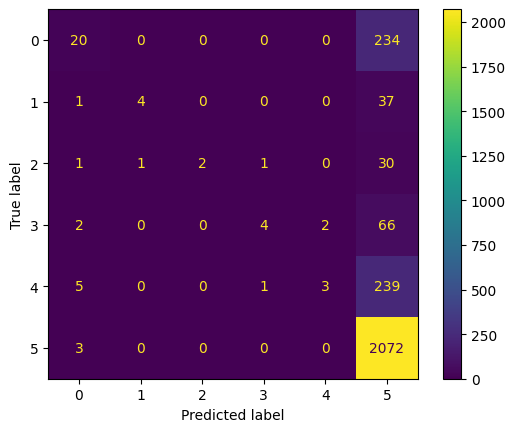

In [45]:
skm.ConfusionMatrixDisplay.from_predictions(ytestKnn, knnPred)

### Confusion Matrix - Logistic Regression


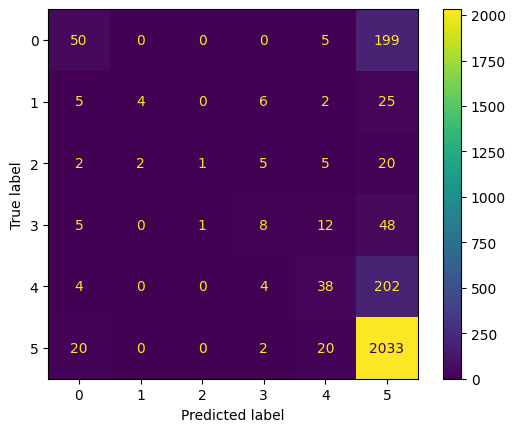

In [46]:
skm.ConfusionMatrixDisplay.from_predictions(ytestLog, logPred)

### Confusion Matrix - XGBoost


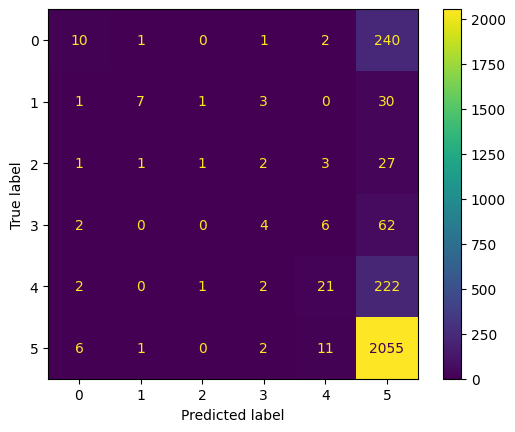

In [47]:
skm.ConfusionMatrixDisplay.from_predictions(ytestXGB, xgbPred)

### Comparison of Precision, Recall, and F1 Score


In [48]:
# Table of precision, recall, f1 scores of all the 3 models
prf = pd.DataFrame(data=
    {
        "Precision": [
            skm.precision_score(ytestKnn, knnPred, average='weighted'),  # KNN precision
            skm.precision_score(ytestLog, logPred, average='weighted'),  # Logistic precision
            skm.precision_score(ytestXGB, xgbPred, average='weighted')   # XGBoost precision
        ],
        "Recall": [
            skm.recall_score(ytestKnn, knnPred, average='weighted'),  # KNN recall
            skm.recall_score(ytestLog, logPred, average='weighted'),  # Logistic recall
            skm.recall_score(ytestXGB, xgbPred, average='weighted')   # XGBoost recall
        ],
        "F1 Score": [
            skm.f1_score(ytestKnn, knnPred, average='weighted'),  # KNN F1 score
            skm.f1_score(ytestLog, logPred, average='weighted'),  # Logistic F1 score
            skm.f1_score(ytestXGB, xgbPred, average='weighted')   # XGBoost F1 score
        ]
    },
    index = ["KNN", "Logistic Regression", "XGBoost"]           
)
prf

,Precision,Recall,F1 Score
KNN,0.74,0.77,0.69
Logistic Regression,0.73,0.78,0.73
XGBoost,0.70,0.77,0.69


- The KNN model gave the highest precision (0.74), followed closely by logistic regression (0.73).

- The recall of all the 3 models was almost the same. Logistic regression marginally outperformed the others with a recall score of 0.78 as against 0.77 for KNN and XGBoost.

- In terms of F1 score too, logistic regression outperformed the other 2 models, with an F1 score of 0.73 against 0.69 for the other 2 models. 

### Comparison of Test Accuracies

1.  KNN - 0.76264
2.  **Logistic Regression - 0.78662 (Best Performing Model)**
3.  XGBoost - 0.77386


# Conclusion

- The dataset was highly imbalanced, affecting the accuracy of the models and the usefulness of some features.

- The following 3 classification models were trained: 
    1. k-nearest neighbors, 
    2. logistic regression, and
    3. xgboost
    
- Most of the features in the dataset were eliminated and the only feature used to train all the above models was `Recipe_Review`, which was a non-numeric, string type column. `Recipe_Review` was transformed using `TFIDFVectorizer`.

- Logistic regression turned out turned out to be the best-performing model, not only in terms of accuracy but in recall score and f1-score as well.